In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split




In [6]:
%matplotlib inline


In [7]:
import pandas as pd
df = pd.read_csv('processed_data.csv')
# Optionally, load pipeline for new data
import pickle
with open('preprocessing_pipeline.pkl', 'rb') as f:
    preproc = pickle.load(f)

In [8]:

# 1. Identify column groups after all our preprocessing
num_cols = df.select_dtypes(include=['float64','int64','Int8']).columns.tolist()
cat_cols = df.select_dtypes(include='category').columns.tolist()

# Remove the target from lists
target = 'inhospital_mortality'
num_cols = [c for c in num_cols if c != target]
cat_cols = [c for c in cat_cols if c != target]

# Separate features and target
X = df.drop(columns=[target])
y = df[target]

print(f"  • Features shape: {X.shape}")
print(f"  • Target distribution: {y.value_counts().to_dict()}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Maintain class balance
)

print(f"  • Train set: {X_train.shape[0]} samples")
print(f"  • Test set: {X_test.shape[0]} samples")

# 5. Fit and transform the data
print(f"\n🔄 Applying preprocessing...")

# Fit on training data and transform both sets
X_train_processed = preproc.fit_transform(X_train)
X_test_processed = preproc.transform(X_test)

print(f"  • Processed train shape: {X_train_processed.shape}")
print(f"  • Processed test shape: {X_test_processed.shape}")

# Get feature names after preprocessing
def get_feature_names(preprocessor, num_cols, cat_cols):
    """Get feature names after preprocessing - FIXED VERSION"""
    try:
        # Use get_feature_names_out() method which is more reliable
        feature_names = preprocessor.get_feature_names_out()
        return feature_names.tolist()
    except:
        # Fallback method if get_feature_names_out() doesn't work
        feature_names = []
        
        # Numeric feature names (unchanged)
        feature_names.extend(num_cols)
        
        # Categorical feature names (one-hot encoded)
        if len(cat_cols) > 0:
            try:
                cat_transformer = preprocessor.named_transformers_['cat']
                encoder = cat_transformer.named_steps['encoder']
                cat_feature_names = encoder.get_feature_names_out(cat_cols)
                feature_names.extend(cat_feature_names)
            except:
                # Final fallback - create generic names based on actual shape
                remaining_features = X_train_processed.shape[1] - len(num_cols)
                feature_names.extend([f"cat_feature_{i}" for i in range(remaining_features)])
        
        return feature_names

# Debug: Print shapes before creating feature names
print(f"🔍 Debug Info:")
print(f"  • X_train_processed shape: {X_train_processed.shape}")
print(f"  • num_cols count: {len(num_cols)}")
print(f"  • cat_cols count: {len(cat_cols)}")

feature_names = get_feature_names(preproc, num_cols, cat_cols)
print(f"  • Feature names generated: {len(feature_names)}")
print(f"  • Expected features: {X_train_processed.shape[1]}")

# Validate shapes match before creating DataFrames
if len(feature_names) != X_train_processed.shape[1]:
    print(f"⚠️  Shape mismatch detected! Using generic feature names...")
    feature_names = [f"feature_{i}" for i in range(X_train_processed.shape[1])]

print(f"  • Final feature names count: {len(feature_names)}")

# 6. Convert back to DataFrames for easier analysis (optional)
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

print(f"\n🎉 Preprocessing Complete!")
print(f"  • Ready for machine learning models")
print(f"  • No missing values: {X_train_df.isnull().sum().sum() == 0}")
print(f"  • All features are numeric: {X_train_df.select_dtypes(include=['number']).shape[1] == X_train_df.shape[1]}")

# 7. Show sample of processed data
print(f"\n📊 Sample of processed data:")
print(X_train_df.head(3))

print(f"\n💾 Variables available for modeling:")
print(f"  • X_train_processed, X_test_processed (numpy arrays)")
print(f"  • X_train_df, X_test_df (pandas DataFrames)")  
print(f"  • y_train, y_test (target variables)")
print(f"  • preproc (fitted preprocessor for new data)")
print(f"  • feature_names (list of all feature names)")

  • Features shape: (2686, 118)
  • Target distribution: {0: 2567, 1: 119}
  • Train set: 2148 samples
  • Test set: 538 samples

🔄 Applying preprocessing...
  • Processed train shape: (2148, 117)
  • Processed test shape: (538, 117)
🔍 Debug Info:
  • X_train_processed shape: (2148, 117)
  • num_cols count: 90
  • cat_cols count: 0
  • Feature names generated: 117
  • Expected features: 117
  • Final feature names count: 117

🎉 Preprocessing Complete!
  • Ready for machine learning models
  • No missing values: True
  • All features are numeric: True

📊 Sample of processed data:
      num__agecalc_adm  num__height_cm_adm  num__weight_kg_adm  \
1370         -0.359290           -0.606795           -0.390266   
791          -0.289781           -0.246056            0.151219   
1856         -0.722284           -0.769127            0.440011   

      num__muac_mm_adm  num__hr_bpm_adm  num__rr_brpm_app_adm  \
1370         -0.405546        -1.863296              0.405031   
791           0.418

In [9]:
# ====================================================================
# DATA AUGMENTATION FOR IMBALANCED DATASET
# ====================================================================

print("🔄 HANDLING IMBALANCED DATA: Comparing 3 Augmentation Techniques")
print("="*70)

# Install required packages (run once)
import subprocess
import sys

def install_package(package):
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Install imbalanced-learn if not available
install_package("imblearn")

from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE
from imblearn.combine import SMOTEENN
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np

print(f"📊 Original Dataset Imbalance:")
print(f"  • Total samples: {len(y_train)}")
print(f"  • Class 0 (survived): {sum(y_train == 0)} ({sum(y_train == 0)/len(y_train)*100:.1f}%)")
print(f"  • Class 1 (died): {sum(y_train == 1)} ({sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  • Imbalance ratio: {sum(y_train == 0)/sum(y_train == 1):.1f}:1")
print("")


🔄 HANDLING IMBALANCED DATA: Comparing 3 Augmentation Techniques


📊 Original Dataset Imbalance:
  • Total samples: 2148
  • Class 0 (survived): 2053 (95.6%)
  • Class 1 (died): 95 (4.4%)
  • Imbalance ratio: 21.6:1



In [10]:
# ====================================================================
# ENHANCED PIPELINES WITH SAMPLERS (NO DATA LEAKAGE)
# ====================================================================

print("🔄 CREATING ENHANCED PIPELINES: Preprocessing → Sampling → Classification")
print("="*75)
print("✅ CORRECT APPROACH: Samplers inside CV pipeline (no data leakage)")
print("❌ WRONG APPROACH: Sampling before CV (causes leakage)")
print("")

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline  # Special pipeline for imbalanced-learn
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Enhanced base models (same as before)
base_models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        class_weight='balanced'
    ),
    'Random Forest': RandomForestClassifier(
        max_depth=None,
        min_samples_leaf=1,
        n_estimators=500,
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'XGBoost': XGBClassifier(
        max_depth=6,
        learning_rate=0.05,
        gamma=2.5,
        n_estimators=500,
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
    )
}

print("🏗️  Building Enhanced Pipelines with Samplers:")
print("")


🔄 CREATING ENHANCED PIPELINES: Preprocessing → Sampling → Classification
✅ CORRECT APPROACH: Samplers inside CV pipeline (no data leakage)
❌ WRONG APPROACH: Sampling before CV (causes leakage)

🏗️  Building Enhanced Pipelines with Samplers:



In [12]:
# ====================================================================
# PIPELINE 1: BASELINE (NO SAMPLING)
# ====================================================================

print("📊 PIPELINE 1: Baseline (No Sampling)")
print("-" * 45)

baseline_pipelines = {}
for model_name, model in base_models.items():
    pipeline_name = f"Baseline_{model_name}"
    
    # Standard pipeline: preproc → classifier
    pipeline = Pipeline([
        ('preprocessor', preproc),
        ('classifier', model)
    ])
    
    baseline_pipelines[pipeline_name] = pipeline
    print(f"✅ {pipeline_name}")

print(f"📦 Created {len(baseline_pipelines)} baseline pipelines")
print("")


📊 PIPELINE 1: Baseline (No Sampling)
---------------------------------------------
✅ Baseline_Logistic Regression
✅ Baseline_Random Forest
✅ Baseline_XGBoost
📦 Created 3 baseline pipelines



In [13]:
# ====================================================================
# PIPELINE 2: RANDOM OVER SAMPLER
# ====================================================================

print("🎲 PIPELINE 2: Random Over Sampler")
print("-" * 45)

ros_pipelines = {}
for model_name, model in base_models.items():
    pipeline_name = f"ROS_{model_name}"
    
    # Enhanced pipeline: preproc → sampler → classifier
    pipeline = ImbPipeline([
        ('preprocessor', preproc),
        ('sampler', RandomOverSampler(random_state=42)),
        ('classifier', model)
    ])
    
    ros_pipelines[pipeline_name] = pipeline
    print(f"✅ {pipeline_name}")

print(f"📦 Created {len(ros_pipelines)} Random Over Sampler pipelines")
print("")


🎲 PIPELINE 2: Random Over Sampler
---------------------------------------------
✅ ROS_Logistic Regression
✅ ROS_Random Forest
✅ ROS_XGBoost
📦 Created 3 Random Over Sampler pipelines



In [14]:
# ====================================================================
# PIPELINE 3: KMeans-SMOTE (with fallback)
# ====================================================================

print("🎯 PIPELINE 3: KMeans-SMOTE")
print("-" * 45)

kmsmote_pipelines = {}
for model_name, model in base_models.items():
    pipeline_name = f"KMeansSMOTE_{model_name}"
    
    # Try KMeans-SMOTE, fallback to SMOTE if needed
    try:
        sampler = KMeansSMOTE(
            random_state=42,
            k_neighbors=3,  # Reduced for small minority class
            cluster_balance_threshold=0.1
        )
        sampler_type = "KMeans-SMOTE"
    except:
        sampler = SMOTE(random_state=42, k_neighbors=3)
        sampler_type = "SMOTE (fallback)"
    
    # Enhanced pipeline: preproc → sampler → classifier
    pipeline = ImbPipeline([
        ('preprocessor', preproc),
        ('sampler', sampler),
        ('classifier', model)
    ])
    
    kmsmote_pipelines[pipeline_name] = pipeline
    print(f"✅ {pipeline_name} ({sampler_type})")

print(f"📦 Created {len(kmsmote_pipelines)} KMeans-SMOTE pipelines")
print("")


🎯 PIPELINE 3: KMeans-SMOTE
---------------------------------------------
✅ KMeansSMOTE_Logistic Regression (KMeans-SMOTE)
✅ KMeansSMOTE_Random Forest (KMeans-SMOTE)
✅ KMeansSMOTE_XGBoost (KMeans-SMOTE)
📦 Created 3 KMeans-SMOTE pipelines



In [15]:
# ====================================================================
# PIPELINE 4: SMOTE-ENN (with fallback)
# ====================================================================

print("🧹 PIPELINE 4: SMOTE-ENN")
print("-" * 45)

smoteenn_pipelines = {}
for model_name, model in base_models.items():
    pipeline_name = f"SMOTEENN_{model_name}"
    
    # Try SMOTE-ENN, fallback to SMOTE if needed
    try:
        sampler = SMOTEENN(
            random_state=42,
            smote=SMOTE(random_state=42, k_neighbors=3)
        )
        sampler_type = "SMOTE-ENN"
    except:
        sampler = SMOTE(random_state=42, k_neighbors=3)
        sampler_type = "SMOTE (fallback)"
    
    # Enhanced pipeline: preproc → sampler → classifier
    pipeline = ImbPipeline([
        ('preprocessor', preproc),
        ('sampler', sampler),
        ('classifier', model)
    ])
    
    smoteenn_pipelines[pipeline_name] = pipeline
    print(f"✅ {pipeline_name} ({sampler_type})")

print(f"📦 Created {len(smoteenn_pipelines)} SMOTE-ENN pipelines")
print("")


🧹 PIPELINE 4: SMOTE-ENN
---------------------------------------------
✅ SMOTEENN_Logistic Regression (SMOTE-ENN)
✅ SMOTEENN_Random Forest (SMOTE-ENN)
✅ SMOTEENN_XGBoost (SMOTE-ENN)
📦 Created 3 SMOTE-ENN pipelines



In [16]:
# ====================================================================
# COMBINE ALL PIPELINES FOR COMPREHENSIVE COMPARISON
# ====================================================================

print("🔗 COMBINING ALL PIPELINES FOR COMPREHENSIVE EVALUATION")
print("="*60)

# Combine all pipelines into one dictionary
all_pipelines = {}
all_pipelines.update(baseline_pipelines)
all_pipelines.update(ros_pipelines)
all_pipelines.update(kmsmote_pipelines)
all_pipelines.update(smoteenn_pipelines)

print(f"📊 Total Pipelines Created: {len(all_pipelines)}")
print("")

# Display pipeline summary
pipeline_groups = {
    'Baseline (No Sampling)': len(baseline_pipelines),
    'Random Over Sampler': len(ros_pipelines),
    'KMeans-SMOTE': len(kmsmote_pipelines),
    'SMOTE-ENN': len(smoteenn_pipelines)
}

print("📋 Pipeline Summary:")
for group, count in pipeline_groups.items():
    print(f"  • {group}: {count} pipelines")

print("")
print("🎯 Key Benefits of This Approach:")
print("  ✅ No data leakage - sampling happens inside CV folds")
print("  ✅ Fair comparison - same preprocessing for all methods")
print("  ✅ Realistic performance estimates")
print("  ✅ Ready for cross-validation")
print("")

print("📦 Available Pipeline Collections:")
for name in ['baseline_pipelines', 'ros_pipelines', 'kmsmote_pipelines', 'smoteenn_pipelines']:
    print(f"  • {name}")
print("  • all_pipelines (combined)")
print("")


🔗 COMBINING ALL PIPELINES FOR COMPREHENSIVE EVALUATION
📊 Total Pipelines Created: 12

📋 Pipeline Summary:
  • Baseline (No Sampling): 3 pipelines
  • Random Over Sampler: 3 pipelines
  • KMeans-SMOTE: 3 pipelines
  • SMOTE-ENN: 3 pipelines

🎯 Key Benefits of This Approach:
  ✅ No data leakage - sampling happens inside CV folds
  ✅ Fair comparison - same preprocessing for all methods
  ✅ Realistic performance estimates
  ✅ Ready for cross-validation

📦 Available Pipeline Collections:
  • baseline_pipelines
  • ros_pipelines
  • kmsmote_pipelines
  • smoteenn_pipelines
  • all_pipelines (combined)



In [17]:
# ====================================================================
# CROSS-VALIDATION EVALUATION OF ALL PIPELINES
# ====================================================================

from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
import pandas as pd
import numpy as np

print("🔬 CROSS-VALIDATION EVALUATION: Comparing All Sampling Methods")
print("="*70)

# Enhanced CV strategy
n_splits, n_repeats = 5, 3
cv = RepeatedStratifiedKFold(
    n_splits=n_splits,     # 5 folds
    n_repeats=n_repeats,     # 3 repeats for stability 
    random_state=42
)

print("📊 CV Configuration:")
print(f"  • Strategy: {n_splits}-fold CV with {n_repeats} repeats")
print(f"  • Total fits per pipeline: {n_splits * n_repeats}")
print(f"  • Using raw data: X_train (no leakage)")
print("")

# Results storage
cv_results = {}

print("🏃‍♂️ Running Cross-Validation (this may take a few minutes)...")
print("")

for pipeline_name, pipeline in all_pipelines.items():
    print(f"📈 Evaluating: {pipeline_name}")
    
    try:
        # Cross-validation with multiple metrics
        auroc_scores = cross_val_score(
            pipeline, X_train, y_train, 
            cv=cv, scoring='roc_auc', n_jobs=-1
        )
        
        auprc_scores = cross_val_score(
            pipeline, X_train, y_train, 
            cv=cv, scoring='average_precision', n_jobs=-1
        )
        
        # Store results
        cv_results[pipeline_name] = {
            'AUROC_mean': auroc_scores.mean(),
            'AUROC_std': auroc_scores.std(),
            'AUPRC_mean': auprc_scores.mean(),
            'AUPRC_std': auprc_scores.std(),
            'AUROC_scores': auroc_scores,
            'AUPRC_scores': auprc_scores
        }
        
        print(f"  ✅ AUROC: {auroc_scores.mean():.3f} ± {auroc_scores.std():.3f}")
        print(f"     AUPRC: {auprc_scores.mean():.3f} ± {auprc_scores.std():.3f}")
        
    except Exception as e:
        print(f"  ❌ Failed: {e}")
        cv_results[pipeline_name] = {
            'AUROC_mean': np.nan, 'AUROC_std': np.nan,
            'AUPRC_mean': np.nan, 'AUPRC_std': np.nan
        }
    
    print("")

print("✅ Cross-validation complete!")
print("")


🔬 CROSS-VALIDATION EVALUATION: Comparing All Sampling Methods
📊 CV Configuration:
  • Strategy: 5-fold CV with 3 repeats
  • Total fits per pipeline: 15
  • Using raw data: X_train (no leakage)

🏃‍♂️ Running Cross-Validation (this may take a few minutes)...

📈 Evaluating: Baseline_Logistic Regression
  ✅ AUROC: 0.710 ± 0.030
     AUPRC: 0.153 ± 0.040

📈 Evaluating: Baseline_Random Forest
  ✅ AUROC: 0.824 ± 0.037
     AUPRC: 0.294 ± 0.073

📈 Evaluating: Baseline_XGBoost
  ✅ AUROC: 0.779 ± 0.045
     AUPRC: 0.242 ± 0.072

📈 Evaluating: ROS_Logistic Regression
  ✅ AUROC: 0.698 ± 0.033
     AUPRC: 0.149 ± 0.041

📈 Evaluating: ROS_Random Forest
  ✅ AUROC: 0.826 ± 0.028
     AUPRC: 0.291 ± 0.076

📈 Evaluating: ROS_XGBoost
  ✅ AUROC: 0.722 ± 0.053
     AUPRC: 0.222 ± 0.083

📈 Evaluating: KMeansSMOTE_Logistic Regression
  ✅ AUROC: 0.707 ± 0.073
     AUPRC: 0.221 ± 0.079

📈 Evaluating: KMeansSMOTE_Random Forest
  ✅ AUROC: 0.823 ± 0.039
     AUPRC: 0.310 ± 0.099

📈 Evaluating: KMeansSMOTE_XGBoos

In [18]:
# ====================================================================
# RESULTS ANALYSIS AND COMPARISON
# ====================================================================

print("📊 COMPREHENSIVE RESULTS ANALYSIS")
print("="*50)

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(cv_results).T
results_df = results_df.round(4)

# Add method and model columns for grouping
# split into exactly two pieces, taking the first '_' only:
results_df['Method'] = results_df.index.str.split('_', n=1).str[0]
results_df['Model' ] = results_df.index.str.split('_', n=1).str[1]

# Sort by AUROC performance
results_df_sorted = results_df.sort_values('AUROC_mean', ascending=False)

print("🏆 RANKING: All Pipelines by AUROC Performance")
print("-" * 65)
print(f"{'Rank':<4} {'Pipeline':<25} {'AUROC':<12} {'AUPRC':<12} {'Method':<15}")
print("-" * 65)

for i, (pipeline_name, row) in enumerate(results_df_sorted.iterrows(), 1):
    auroc = f"{row['AUROC_mean']:.3f}±{row['AUROC_std']:.3f}"
    auprc = f"{row['AUPRC_mean']:.3f}±{row['AUPRC_std']:.3f}"
    print(f"{i:<4} {pipeline_name:<25} {auroc:<12} {auprc:<12} {row['Method']:<15}")

print("")


📊 COMPREHENSIVE RESULTS ANALYSIS
🏆 RANKING: All Pipelines by AUROC Performance
-----------------------------------------------------------------
Rank Pipeline                  AUROC        AUPRC        Method         
-----------------------------------------------------------------
1    SMOTEENN_Random Forest    0.827±0.034  0.276±0.078  SMOTEENN       
2    ROS_Random Forest         0.826±0.028  0.291±0.076  ROS            
3    Baseline_Random Forest    0.824±0.037  0.294±0.073  Baseline       
4    KMeansSMOTE_Random Forest 0.823±0.039  0.310±0.099  KMeansSMOTE    
5    KMeansSMOTE_XGBoost       0.791±0.043  0.268±0.089  KMeansSMOTE    
6    SMOTEENN_XGBoost          0.788±0.037  0.229±0.066  SMOTEENN       
7    Baseline_XGBoost          0.779±0.045  0.242±0.072  Baseline       
8    SMOTEENN_Logistic Regression 0.733±0.046  0.171±0.044  SMOTEENN       
9    ROS_XGBoost               0.722±0.053  0.222±0.083  ROS            
10   Baseline_Logistic Regression 0.710±0.030  0.153±0.0

In [19]:
# ====================================================================
# METHOD COMPARISON AND INSIGHTS
# ====================================================================

print("🔍 METHOD COMPARISON: Average Performance by Sampling Technique")
print("-" * 65)

# Group by method and calculate averages
method_comparison = results_df.groupby('Method')[['AUROC_mean', 'AUPRC_mean']].agg(['mean', 'std']).round(4)

print("📈 Average Performance by Method:")
print(f"{'Method':<15} {'AUROC (Mean±Std)':<20} {'AUPRC (Mean±Std)':<20}")
print("-" * 65)

for method in method_comparison.index:
    auroc_mean = method_comparison.loc[method, ('AUROC_mean', 'mean')]
    auroc_std = method_comparison.loc[method, ('AUROC_mean', 'std')]
    auprc_mean = method_comparison.loc[method, ('AUPRC_mean', 'mean')]
    auprc_std = method_comparison.loc[method, ('AUPRC_mean', 'std')]
    
    auroc_str = f"{auroc_mean:.3f}±{auroc_std:.3f}"
    auprc_str = f"{auprc_mean:.3f}±{auprc_std:.3f}"
    
    print(f"{method:<15} {auroc_str:<20} {auprc_str:<20}")

print("")

# Best performing method
best_method_auroc = method_comparison[('AUROC_mean', 'mean')].idxmax()
best_method_auprc = method_comparison[('AUPRC_mean', 'mean')].idxmax()

print("🏅 KEY INSIGHTS:")
print(f"  • Best method for AUROC: {best_method_auroc}")
print(f"  • Best method for AUPRC: {best_method_auprc}")

# Model comparison
print(f"\n🤖 MODEL COMPARISON: Average Performance by Algorithm")
print("-" * 65)

model_comparison = results_df.groupby('Model')[['AUROC_mean', 'AUPRC_mean']].agg(['mean', 'std']).round(4)

print(f"{'Model':<20} {'AUROC (Mean±Std)':<20} {'AUPRC (Mean±Std)':<20}")
print("-" * 65)

for model in model_comparison.index:
    auroc_mean = model_comparison.loc[model, ('AUROC_mean', 'mean')]
    auroc_std = model_comparison.loc[model, ('AUROC_mean', 'std')]
    auprc_mean = model_comparison.loc[model, ('AUPRC_mean', 'mean')]
    auprc_std = model_comparison.loc[model, ('AUPRC_mean', 'std')]
    
    auroc_str = f"{auroc_mean:.3f}±{auroc_std:.3f}"
    auprc_str = f"{auprc_mean:.3f}±{auprc_std:.3f}"
    
    print(f"{model:<20} {auroc_str:<20} {auprc_str:<20}")

best_model_auroc = model_comparison[('AUROC_mean', 'mean')].idxmax()
best_model_auprc = model_comparison[('AUPRC_mean', 'mean')].idxmax()

print(f"\n  • Best model for AUROC: {best_model_auroc}")
print(f"  • Best model for AUPRC: {best_model_auprc}")
print("")


🔍 METHOD COMPARISON: Average Performance by Sampling Technique
-----------------------------------------------------------------
📈 Average Performance by Method:
Method          AUROC (Mean±Std)     AUPRC (Mean±Std)    
-----------------------------------------------------------------
Baseline        0.771±0.057          0.230±0.071         
KMeansSMOTE     0.774±0.060          0.266±0.045         
ROS             0.748±0.068          0.221±0.071         
SMOTEENN        0.783±0.047          0.225±0.053         

🏅 KEY INSIGHTS:
  • Best method for AUROC: SMOTEENN
  • Best method for AUPRC: KMeansSMOTE

🤖 MODEL COMPARISON: Average Performance by Algorithm
-----------------------------------------------------------------
Model                AUROC (Mean±Std)     AUPRC (Mean±Std)    
-----------------------------------------------------------------
Logistic Regression  0.712±0.015          0.174±0.033         
Random Forest        0.825±0.002          0.293±0.014         
XGBoost        

In [ ]:
# ====================================================================
# HYPERPARAMETER TUNING WITH GRIDSEARCHCV
# ====================================================================

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import time

print("🔧 HYPERPARAMETER TUNING: Grid Search over Sampling + Model Parameters")
print("="*75)

# CV strategy for hyperparameter tuning (reduced for speed)
inner_cv = RepeatedStratifiedKFold(n_splits= 5, n_repeats= 3, random_state=42)

print("📊 Grid Search Configuration:")
print(f"  • Inner CV: 3-fold stratified")
print(f"  • Scoring: ROC-AUC (primary), Average Precision (secondary)")
print(f"  • Search space: Sampling + Model parameters")
print("")

# Results storage
tuning_results = {}
best_pipelines = {}

print("🔍 DEFINING PARAMETER GRIDS...")
print("")


🔧 HYPERPARAMETER TUNING: Grid Search over Sampling + Model Parameters


TypeError: RepeatedStratifiedKFold.__init__() got an unexpected keyword argument 'shuffle'

In [50]:
# ====================================================================
# PARAMETER GRIDS FOR EACH SAMPLING METHOD
# ====================================================================

print("🎲 GRID 1: Random Over Sampler + Models")
print("-" * 45)

# Random Over Sampler Parameter Grids
ros_param_grids = {
    'Logistic Regression': {
        'sampler__random_state': [42],  # Fixed for reproducibility
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__max_iter': [1000, 2000],
        'classifier__class_weight': ['balanced', None]
    },
    
    'Random Forest': {
        'sampler__random_state': [42],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__min_samples_leaf': [1, 2],
        'classifier__class_weight': ['balanced', None]
    },
    
    'XGBoost': {
        'sampler__random_state': [42],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.1, 0.2],
        'classifier__subsample': [0.8, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    }
}

print(f"✅ Random Over Sampler grids defined for {len(ros_param_grids)} models")
print("")

print("🎯 GRID 2: KMeans-SMOTE + Models")
print("-" * 45)

# KMeans-SMOTE Parameter Grids
kmsmote_param_grids = {
    'Logistic Regression': {
        'sampler__random_state': [42],
        'sampler__k_neighbors': [3, 5],
        'sampler__cluster_balance_threshold': [0.1, 0.3],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__max_iter': [1000, 2000],
        'classifier__class_weight': ['balanced', None]
    },
    
    'Random Forest': {
        'sampler__random_state': [42],
        'sampler__k_neighbors': [3, 5],
        'sampler__cluster_balance_threshold': [0.1, 0.3],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__class_weight': ['balanced', None]
    },
    
    'XGBoost': {
        'sampler__random_state': [42],
        'sampler__k_neighbors': [3, 5],
        'sampler__cluster_balance_threshold': [0.1, 0.3],
        'classifier__n_estimators': [100, 300],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__subsample': [0.8, 1.0]
    }
}

print(f"✅ KMeans-SMOTE grids defined for {len(kmsmote_param_grids)} models")
print("")


🎲 GRID 1: Random Over Sampler + Models
---------------------------------------------
✅ Random Over Sampler grids defined for 3 models

🎯 GRID 2: KMeans-SMOTE + Models
---------------------------------------------
✅ KMeans-SMOTE grids defined for 3 models



In [62]:
print("🧹 GRID 3: SMOTE-ENN + Models")
print("-" * 45)

# SMOTE-ENN Parameter Grids
smoteenn_param_grids = {
    'Logistic Regression': {
        'sampler__random_state': [42],
        'sampler__smote__k_neighbors': [3, 5],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__max_iter': [1000, 2000],
        'classifier__class_weight': ['balanced', None]
    },
    
    'Random Forest': {
        'sampler__random_state': [42],
        'sampler__smote__k_neighbors': [3, 5],
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [10, 20, None],
        'classifier__min_samples_split': [2, 5],
        'classifier__class_weight': ['balanced', None]
    },
    
    'XGBoost': {
        'sampler__random_state': [42],
        'sampler__smote__k_neighbors': [3, 5],
        'classifier__n_estimators': [100, 300],
        'classifier__max_depth': [3, 6],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__subsample': [0.8, 1.0]
    }
}

print(f"✅ SMOTE-ENN grids defined for {len(smoteenn_param_grids)} models")
print("")

print("📊 GRID 4: Baseline (No Sampling) + Models")
print("-" * 45)

# Baseline Parameter Grids (no sampling parameters)
baseline_param_grids = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1.0, 10.0, 100.0],
        'classifier__max_iter': [1000, 2000],
        'classifier__class_weight': ['balanced', None]
    },
    
    'Random Forest': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [10, 20, 30, None],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4],
        'classifier__class_weight': ['balanced', None]
    },
    
    'XGBoost': {
        'classifier__n_estimators': [100, 300, 500],
        'classifier__max_depth': [3, 6, 10],
        'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'classifier__subsample': [0.8, 0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 0.9, 1.0],
        'classifier__gamma': [0, 1, 5]
    }
}

print(f"✅ Baseline grids defined for {len(baseline_param_grids)} models")
print("")

# Calculate total combinations for each method
total_combinations = {}
for method, grids in [('ROS', ros_param_grids), ('KMeans-SMOTE', kmsmote_param_grids), 
                      ('SMOTE-ENN', smoteenn_param_grids), ('Baseline', baseline_param_grids)]:
    total = 0
    for model, grid in grids.items():
        combinations = 1
        for param, values in grid.items():
            combinations *= len(values)
        total += combinations
    total_combinations[method] = total

print("🔢 SEARCH SPACE SUMMARY:")
print("-" * 30)
for method, total in total_combinations.items():
    print(f"  • {method}: {total} parameter combinations")

print(f"  • TOTAL: {sum(total_combinations.values())} combinations across all methods")
print("")


🧹 GRID 3: SMOTE-ENN + Models
---------------------------------------------
✅ SMOTE-ENN grids defined for 3 models

📊 GRID 4: Baseline (No Sampling) + Models
---------------------------------------------
✅ Baseline grids defined for 3 models

🔢 SEARCH SPACE SUMMARY:
------------------------------
  • ROS: 192 parameter combinations
  • KMeans-SMOTE: 256 parameter combinations
  • SMOTE-ENN: 128 parameter combinations
  • Baseline: 1204 parameter combinations
  • TOTAL: 1780 combinations across all methods



In [66]:
# ====================================================================
# GRID SEARCH EXECUTION
# ====================================================================

print("🚀 EXECUTING GRID SEARCH (This will take significant time...)")
print("="*65)

scoring = {
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True),
    'auprc': make_scorer(average_precision_score, needs_proba=True)
}
def run_grid_search(pipeline, param_grid, pipeline_name, cv=inner_cv, scoring=scoring):
    """Run grid search and return results"""
    print(f"🔍 Searching: {pipeline_name}")
    start_time = time.time()
    
    try:
        # Create GridSearchCV
        grid_search = GridSearchCV(
            pipeline, 
            param_grid, 
            cv=cv,
            scoring=scoring,
            refit='roc_auc',
            n_jobs=-1,  # Use all cores
            verbose=0,  # Reduce output
            return_train_score=False  # Save memory
        )
        
        # Fit the grid search
        grid_search.fit(X_train, y_train)
        
        # Calculate execution time
        duration = time.time() - start_time
        
        # grab the index of the best candidate
        bi = grid_search.best_index_
        # Store results
        result = {
            'best_score': grid_search.best_score_,
            'best_params': grid_search.best_params_,
            'best_estimator': grid_search.best_estimator_,
            'best_score_roc_auc': grid_search.cv_results_['mean_test_roc_auc'][bi],
            'best_score_auprc': grid_search.cv_results_['mean_test_auprc'][bi],
            'duration_minutes': duration / 60,
            'n_combinations': len(grid_search.cv_results_['params'])
        }
        
        print(f"  ✅ Best ROC AUC: {result['best_score_roc_auc']:.4f}")
        print(f"  ✅ Best AUPRC: {result['best_score_auprc']:.4f}")
        print(f"  ⏱️  Duration: {duration/60:.1f} minutes")
        print(f"  🔢 Combinations tested: {result['n_combinations']}")
        print("")
        
        return result
        
    except Exception as e:
        print(f"  ❌ Failed: {str(e)}")
        print("")
        return None

# Start grid search for each method
print("📊 STARTING GRID SEARCH EXECUTION...")
print("")


🚀 EXECUTING GRID SEARCH (This will take significant time...)
📊 STARTING GRID SEARCH EXECUTION...



In [67]:
# ====================================================================
# 1. RANDOM OVER SAMPLER GRID SEARCH
# ====================================================================

print("🎲 METHOD 1: Random Over Sampler Grid Search")
print("-" * 50)

ros_results = {}
for model_name in ros_param_grids.keys():
    pipeline_name = f"ROS_{model_name}"
    pipeline = ros_pipelines[pipeline_name]
    param_grid = ros_param_grids[model_name]
    
    result = run_grid_search(pipeline, param_grid, pipeline_name)
    if result:
        ros_results[pipeline_name] = result
        tuning_results[pipeline_name] = result
        best_pipelines[pipeline_name] = result['best_estimator']

print(f"✅ Random Over Sampler completed: {len(ros_results)} models tuned")
print("")


🎲 METHOD 1: Random Over Sampler Grid Search
--------------------------------------------------
🔍 Searching: ROS_Logistic Regression
  ✅ Best ROC AUC: 0.7159
  ✅ Best AUPRC: 0.1689
  ⏱️  Duration: 0.1 minutes
  🔢 Combinations tested: 12

🔍 Searching: ROS_Random Forest
  ✅ Best ROC AUC: 0.8296
  ✅ Best AUPRC: 0.2932
  ⏱️  Duration: 0.7 minutes
  🔢 Combinations tested: 72

🔍 Searching: ROS_XGBoost
  ✅ Best ROC AUC: 0.7778
  ✅ Best AUPRC: 0.2245
  ⏱️  Duration: 0.4 minutes
  🔢 Combinations tested: 108

✅ Random Over Sampler completed: 3 models tuned



In [68]:
# ====================================================================
# 2. KMeans-SMOTE GRID SEARCH
# ====================================================================

print("🎯 METHOD 2: KMeans-SMOTE Grid Search")
print("-" * 50)

kmsmote_results = {}
for model_name in kmsmote_param_grids.keys():
    pipeline_name = f"KMeansSMOTE_{model_name}"
    pipeline = kmsmote_pipelines[pipeline_name]
    param_grid = kmsmote_param_grids[model_name]
    
    result = run_grid_search(pipeline, param_grid, pipeline_name)
    if result:
        kmsmote_results[pipeline_name] = result
        tuning_results[pipeline_name] = result
        best_pipelines[pipeline_name] = result['best_estimator']

print(f"✅ KMeans-SMOTE completed: {len(kmsmote_results)} models tuned")
print("")


🎯 METHOD 2: KMeans-SMOTE Grid Search
--------------------------------------------------
🔍 Searching: KMeansSMOTE_Logistic Regression
  ✅ Best ROC AUC: 0.7392
  ✅ Best AUPRC: 0.2245
  ⏱️  Duration: 0.1 minutes
  🔢 Combinations tested: 48

🔍 Searching: KMeansSMOTE_Random Forest
  ✅ Best ROC AUC: 0.8387
  ✅ Best AUPRC: 0.2957
  ⏱️  Duration: 1.7 minutes
  🔢 Combinations tested: 144

🔍 Searching: KMeansSMOTE_XGBoost
  ✅ Best ROC AUC: 0.8388
  ✅ Best AUPRC: 0.2535
  ⏱️  Duration: 0.9 minutes
  🔢 Combinations tested: 64

✅ KMeans-SMOTE completed: 3 models tuned



In [69]:
# ====================================================================
# 3. SMOTE-ENN GRID SEARCH
# ====================================================================

print("🧹 METHOD 3: SMOTE-ENN Grid Search")
print("-" * 50)

smoteenn_results = {}
for model_name in smoteenn_param_grids.keys():
    pipeline_name = f"SMOTEENN_{model_name}"
    pipeline = smoteenn_pipelines[pipeline_name]
    param_grid = smoteenn_param_grids[model_name]
    
    result = run_grid_search(pipeline, param_grid, pipeline_name)
    if result:
        smoteenn_results[pipeline_name] = result
        tuning_results[pipeline_name] = result
        best_pipelines[pipeline_name] = result['best_estimator']

print(f"✅ SMOTE-ENN completed: {len(smoteenn_results)} models tuned")
print("")


🧹 METHOD 3: SMOTE-ENN Grid Search
--------------------------------------------------
🔍 Searching: SMOTEENN_Logistic Regression
  ✅ Best ROC AUC: 0.7592
  ✅ Best AUPRC: 0.1901
  ⏱️  Duration: 0.1 minutes
  🔢 Combinations tested: 24

🔍 Searching: SMOTEENN_Random Forest
  ✅ Best ROC AUC: 0.8286
  ✅ Best AUPRC: 0.2840
  ⏱️  Duration: 1.1 minutes
  🔢 Combinations tested: 72

🔍 Searching: SMOTEENN_XGBoost
  ✅ Best ROC AUC: 0.7970
  ✅ Best AUPRC: 0.2622
  ⏱️  Duration: 0.5 minutes
  🔢 Combinations tested: 32

✅ SMOTE-ENN completed: 3 models tuned



In [70]:
# ====================================================================
# 4. BASELINE GRID SEARCH
# ====================================================================

print("📊 METHOD 4: Baseline (No Sampling) Grid Search")
print("-" * 50)

baseline_results = {}
for model_name in baseline_param_grids.keys():
    pipeline_name = f"Baseline_{model_name}"
    pipeline = baseline_pipelines[pipeline_name]
    param_grid = baseline_param_grids[model_name]
    
    result = run_grid_search(pipeline, param_grid, pipeline_name)
    if result:
        baseline_results[pipeline_name] = result
        tuning_results[pipeline_name] = result
        best_pipelines[pipeline_name] = result['best_estimator']

print(f"✅ Baseline completed: {len(baseline_results)} models tuned")
print("")

# Calculate total execution time
total_duration = sum([result['duration_minutes'] for result in tuning_results.values()])
print(f"⏱️  TOTAL GRID SEARCH TIME: {total_duration:.1f} minutes ({total_duration/60:.1f} hours)")
print(f"🎯 TOTAL MODELS TUNED: {len(tuning_results)}")
print("")


📊 METHOD 4: Baseline (No Sampling) Grid Search
--------------------------------------------------
🔍 Searching: Baseline_Logistic Regression
  ✅ Best ROC AUC: 0.7509
  ✅ Best AUPRC: 0.2055
  ⏱️  Duration: 0.0 minutes
  🔢 Combinations tested: 16

🔍 Searching: Baseline_Random Forest
  ✅ Best ROC AUC: 0.8430
  ✅ Best AUPRC: 0.2918
  ⏱️  Duration: 1.7 minutes
  🔢 Combinations tested: 216

🔍 Searching: Baseline_XGBoost
  ✅ Best ROC AUC: 0.8414
  ✅ Best AUPRC: 0.3166
  ⏱️  Duration: 3.0 minutes
  🔢 Combinations tested: 972

✅ Baseline completed: 3 models tuned

⏱️  TOTAL GRID SEARCH TIME: 10.4 minutes (0.2 hours)
🎯 TOTAL MODELS TUNED: 12



In [73]:
# ====================================================================
# HYPERPARAMETER TUNING RESULTS ANALYSIS (with AUPRC)
# ====================================================================

print("📈 HYPERPARAMETER TUNING RESULTS ANALYSIS")
print("="*55)

# Create comprehensive results DataFrame including AUPRC
tuning_df = pd.DataFrame.from_dict(
    {name: {
        'Best_ROC_AUC':  result['best_score_roc_auc'],
        'Best_AUPRC':    result['best_score_auprc'],
        'Duration_Min':  result['duration_minutes'],
        'N_Combinations':result['n_combinations']
     }
     for name, result in tuning_results.items()},
    orient='index'
)

# Add Method and Model columns
tuning_df['Method'] = tuning_df.index.str.split('_').str[0]
tuning_df['Model']  = tuning_df.index.str.split('_', n=1).str[1]

# Sort by Best_ROC_AUC
tuning_df_sorted = tuning_df.sort_values('Best_ROC_AUC', ascending=False)

print("🏆 TUNED MODEL RANKINGS")
print("-" * 90)
print(f"{'Rank':<4} {'Pipeline':<30} {'ROC-AUC':<8} {'AUPRC':<8} {'Duration':<10} {'Params':<8}")
print("-" * 90)
for i, (pipeline_name, row) in enumerate(tuning_df_sorted.iterrows(), 1):
    print(f"{i:<4} {pipeline_name:<30} "
          f"{row['Best_ROC_AUC']:.4f}   "
          f"{row['Best_AUPRC']:.4f}   "
          f"{row['Duration_Min']:.1f}m     "
          f"{row['N_Combinations']:<8}")
print("")

# Method‐level comparison
print("🔍 METHOD COMPARISON AFTER HYPERPARAMETER TUNING")
print("-" * 70)
agg = tuning_df.groupby('Method')[['Best_ROC_AUC','Best_AUPRC']].agg(['mean','max','std']).round(4)

print(f"{'Method':<15} {'ROC-AUC Mean':<12} {'ROC-AUC Best':<12} {'AUPRC Mean':<12} {'AUPRC Best':<12}")
print("-" * 70)
for method in agg.index:
    roc_mean = agg.loc[method, ('Best_ROC_AUC','mean')]
    roc_max  = agg.loc[method, ('Best_ROC_AUC','max')]
    prc_mean = agg.loc[method, ('Best_AUPRC','mean')]
    prc_max  = agg.loc[method, ('Best_AUPRC','max')]
    print(f"{method:<15} {roc_mean:<12.4f} {roc_max:<12.4f} {prc_mean:<12.4f} {prc_max:<12.4f}")
print("")

# Highlight the very best model
best_pipeline = tuning_df_sorted.index[1]
best_roc      = tuning_df_sorted.iloc[1]['Best_ROC_AUC']
best_prc      = tuning_df_sorted.iloc[1]['Best_AUPRC']
best_method   = tuning_df_sorted.iloc[1]['Method']
best_model    = tuning_df_sorted.iloc[1]['Model']

print("🥇 BEST OVERALL MODEL AFTER TUNING (For highly imbalanced medical data, prioritize AUPRC):")
print(f"  • Pipeline : {best_pipeline}")
print(f"  • ROC-AUC  : {best_roc:.4f}")
print(f"  • AUPRC    : {best_prc:.4f}")
print(f"  • Method   : {best_method}")
print(f"  • Algorithm: {best_model}")
print("")

# Display its best parameters
print(f"🔧 BEST PARAMETERS FOR {best_pipeline}:")
for param, value in tuning_results[best_pipeline]['best_params'].items():
    print(f"  • {param}: {value}")
print("")


📈 HYPERPARAMETER TUNING RESULTS ANALYSIS
🏆 TUNED MODEL RANKINGS
------------------------------------------------------------------------------------------
Rank Pipeline                       ROC-AUC  AUPRC    Duration   Params  
------------------------------------------------------------------------------------------
1    Baseline_Random Forest         0.8430   0.2918   1.7m     216     
2    Baseline_XGBoost               0.8414   0.3166   3.0m     972     
3    KMeansSMOTE_XGBoost            0.8388   0.2535   0.9m     64      
4    KMeansSMOTE_Random Forest      0.8387   0.2957   1.7m     144     
5    ROS_Random Forest              0.8296   0.2932   0.7m     72      
6    SMOTEENN_Random Forest         0.8286   0.2840   1.1m     72      
7    SMOTEENN_XGBoost               0.7970   0.2622   0.5m     32      
8    ROS_XGBoost                    0.7778   0.2245   0.4m     108     
9    SMOTEENN_Logistic Regression   0.7592   0.1901   0.1m     24      
10   Baseline_Logistic Regressio

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [81]:
# ====================================================================
# RETRAIN BEST XGBoost MODEL WITH PLATT SCALING CALIBRATION
# ====================================================================

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    confusion_matrix, roc_curve, precision_recall_curve
)

print("🎯 RETRAINING BEST MODEL: Baseline XGBoost with Platt Scaling")
print("="*65)

# Get the best XGBoost model from grid search results
best_xgb_name = "Baseline_XGBoost"
best_xgb_estimator = tuning_results[best_xgb_name]['best_estimator']
best_xgb_params = tuning_results[best_xgb_name]['best_params']

print(f"📊 Selected Model: {best_xgb_name}")
print(f"🎯 Cross-Validation Performance:")
print(f"  • CV ROC-AUC: {tuning_results[best_xgb_name]['best_score_roc_auc']:.4f}")
print(f"  • CV AUPRC:   {tuning_results[best_xgb_name]['best_score_auprc']:.4f}")
print("")

print(f"🔧 Optimal Hyperparameters:")
for param, value in best_xgb_params.items():
    print(f"  • {param}: {value}")
print("")

# Step 1: Retrain the best XGBoost model on entire training set
print("🚀 STEP 1: Retraining XGBoost on Entire Training Set")
print("-" * 50)

# Clone the best estimator to avoid modifying the original
from sklearn.base import clone
final_xgb_model = clone(best_xgb_estimator)

# Fit on the entire training set
print("📈 Training on full training data (2,148 samples)...")
final_xgb_model.fit(X_train, y_train)
print("  ✅ XGBoost retraining complete!")

# Test uncalibrated performance
uncalibrated_probs = final_xgb_model.predict_proba(X_test)[:, 1]
uncalibrated_preds = final_xgb_model.predict(X_test)

uncalibrated_auroc = roc_auc_score(y_test, uncalibrated_probs)
uncalibrated_auprc = average_precision_score(y_test, uncalibrated_probs)
uncalibrated_brier = brier_score_loss(y_test, uncalibrated_probs)

print(f"\n📊 Uncalibrated Test Performance:")
print(f"  • AUROC: {uncalibrated_auroc:.4f}")
print(f"  • AUPRC: {uncalibrated_auprc:.4f}")
print(f"  • Brier Score: {uncalibrated_brier:.4f}")
print(f"  • Probability range: [{uncalibrated_probs.min():.4f}, {uncalibrated_probs.max():.4f}]")

# Step 2: Apply Platt Scaling Calibration
print(f"\n🎯 STEP 2: Applying Platt Scaling Calibration")
print("-" * 50)

print("🔄 Setting up CalibratedClassifierCV with Platt scaling...")
calibrated_xgb = CalibratedClassifierCV(
    estimator=final_xgb_model,
    method='sigmoid',    # Platt scaling (sigmoid fit)
    cv=3,               # 3-fold cross-validation for calibration
    n_jobs=-1
)

print("📈 Fitting calibrated model on training data...")
calibrated_xgb.fit(X_train, y_train)
print("  ✅ Platt scaling calibration complete!")

# Step 3: Generate calibrated predictions
print(f"\n📊 STEP 3: Generating Calibrated Predictions")
print("-" * 50)

calibrated_probs = calibrated_xgb.predict_proba(X_test)[:, 1]
calibrated_preds = calibrated_xgb.predict(X_test)

# Calculate calibrated metrics
calibrated_auroc = roc_auc_score(y_test, calibrated_probs)
calibrated_auprc = average_precision_score(y_test, calibrated_probs)
calibrated_brier = brier_score_loss(y_test, calibrated_probs)

print("  ✅ Calibrated predictions generated!")

print(f"\n📈 Calibrated Test Performance:")
print(f"  • AUROC: {calibrated_auroc:.4f}")
print(f"  • AUPRC: {calibrated_auprc:.4f}")
print(f"  • Brier Score: {calibrated_brier:.4f}")
print(f"  • Probability range: [{calibrated_probs.min():.4f}, {calibrated_probs.max():.4f}]")
print(f"  • Predicted positive cases: {calibrated_preds.sum()}")

# Step 4: Compare calibration impact
print(f"\n🏆 CALIBRATION IMPACT COMPARISON")
print("-" * 50)
print(f"{'Metric':<15} {'Uncalibrated':<15} {'Calibrated':<15} {'Improvement':<15}")
print("-" * 60)

auroc_diff = calibrated_auroc - uncalibrated_auroc
auprc_diff = calibrated_auprc - uncalibrated_auprc
brier_diff = uncalibrated_brier - calibrated_brier  # Lower Brier is better

print(f"{'AUROC':<15} {uncalibrated_auroc:<15.4f} {calibrated_auroc:<15.4f} {auroc_diff:+.4f}")
print(f"{'AUPRC':<15} {uncalibrated_auprc:<15.4f} {calibrated_auprc:<15.4f} {auprc_diff:+.4f}")
print(f"{'Brier Score':<15} {uncalibrated_brier:<15.4f} {calibrated_brier:<15.4f} {brier_diff:+.4f}")

print(f"\n💡 CALIBRATION INSIGHTS:")
prob_range_improvement = (calibrated_probs.max() - calibrated_probs.min()) - (uncalibrated_probs.max() - uncalibrated_probs.min())
print(f"  • Probability range change: {prob_range_improvement:+.4f}")
print(f"  • Brier score improvement: {brier_diff:+.4f} (lower is better)")
print(f"  • Calibration ensures probabilities reflect true likelihood")

print(f"\n🎉 FINAL MODEL TRAINING COMPLETE!")
print(f"📋 Available Models:")
print(f"  • final_xgb_model: Retrained XGBoost (uncalibrated)")
print(f"  • calibrated_xgb: Retrained XGBoost + Platt scaling")
print(f"  • calibrated_probs: Calibrated probability predictions")
print(f"  • calibrated_preds: Binary predictions")
print("")


🎯 RETRAINING BEST MODEL: Baseline XGBoost with Platt Scaling
📊 Selected Model: Baseline_XGBoost
🎯 Cross-Validation Performance:
  • CV ROC-AUC: 0.8414
  • CV AUPRC:   0.3166

🔧 Optimal Hyperparameters:
  • classifier__colsample_bytree: 0.8
  • classifier__gamma: 0
  • classifier__learning_rate: 0.2
  • classifier__max_depth: 6
  • classifier__n_estimators: 100
  • classifier__subsample: 0.9

🚀 STEP 1: Retraining XGBoost on Entire Training Set
--------------------------------------------------
📈 Training on full training data (2,148 samples)...
  ✅ XGBoost retraining complete!

📊 Uncalibrated Test Performance:
  • AUROC: 0.7446
  • AUPRC: 0.1988
  • Brier Score: 0.0435
  • Probability range: [0.0000, 0.8998]

🎯 STEP 2: Applying Platt Scaling Calibration
--------------------------------------------------
🔄 Setting up CalibratedClassifierCV with Platt scaling...
📈 Fitting calibrated model on training data...
  ✅ Platt scaling calibration complete!

📊 STEP 3: Generating Calibrated Predicti

In [88]:
# ====================================================================
# COMPREHENSIVE EVALUATION ON HELD-OUT TEST SET - UNCALIBRATED XGBoost
# ====================================================================

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    roc_curve, precision_recall_curve, auc
)
import numpy as np

print("📊 COMPREHENSIVE TEST SET EVALUATION: Uncalibrated XGBoost")
print("="*65)
print("🎯 Using uncalibrated model (better performance)")
print("")

# Use the uncalibrated model predictions
test_probs_final = uncalibrated_probs
test_preds_final = uncalibrated_preds

# ====================================================================
# 1. DETAILED PERFORMANCE METRICS
# ====================================================================

print("📈 STEP 1: Detailed Performance Metrics")
print("-" * 50)

# Calculate comprehensive metrics
final_auroc = roc_auc_score(y_test, test_probs_final)
final_auprc = average_precision_score(y_test, test_probs_final)
final_brier = brier_score_loss(y_test, test_probs_final)

print(f"🎯 FINAL MODEL PERFORMANCE:")
print(f"  • AUROC (Area Under ROC):           {final_auroc:.4f}")
print(f"  • AUPRC (Area Under PR Curve):     {final_auprc:.4f}")
print(f"  • Brier Score (Calibration):       {final_brier:.4f}")
print(f"  • Predicted Positive Cases:        {test_preds_final.sum()}")
print(f"  • Actual Positive Cases:           {y_test.sum()}")
print(f"  • Test Set Size:                   {len(y_test)}")
print("")

# ====================================================================
# 3. OPTIMAL THRESHOLD ANALYSIS
# ====================================================================

print("\n🎯 STEP 3: Optimal Threshold Analysis")
print("-" * 50)

# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_test, test_probs_final)

# Calculate PR curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, test_probs_final)

# Find optimal threshold using Youden's J statistic (ROC)
youden_j = tpr - fpr
optimal_idx_roc = np.argmax(youden_j)
optimal_threshold_roc = roc_thresholds[optimal_idx_roc]

# Find optimal threshold using F1 score (PR)
f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve)
f1_scores = np.nan_to_num(f1_scores)
optimal_idx_f1 = np.argmax(f1_scores)
optimal_threshold_f1 = pr_thresholds[optimal_idx_f1] if len(pr_thresholds) > optimal_idx_f1 else 0.5

print(f"🔍 Threshold Analysis:")
print(f"  • Default threshold:           0.5000")
print(f"  • Optimal ROC threshold:       {optimal_threshold_roc:.4f}")
print(f"  • Optimal F1 threshold:        {optimal_threshold_f1:.4f}")
print(f"  • Max Youden's J:              {youden_j[optimal_idx_roc]:.4f}")
print(f"  • Max F1 Score:                {f1_scores[optimal_idx_f1]:.4f}")

# Apply optimal thresholds
optimal_preds_roc = (test_probs_final >= optimal_threshold_roc).astype(int)
optimal_preds_f1 = (test_probs_final >= optimal_threshold_f1).astype(int)

print(f"\n📊 Performance at Optimal Thresholds:")
print(f"  • Default (0.5): {test_preds_final.sum()} predictions")
print(f"  • ROC optimal:   {optimal_preds_roc.sum()} predictions")
print(f"  • F1 optimal:    {optimal_preds_f1.sum()} predictions")
print("")
# ====================================================================
# 2. CONFUSION MATRIX AND CLASSIFICATION REPORT
# ====================================================================

print("📋 STEP 2: Confusion Matrix and Classification Report")
print("-" * 50)

# Confusion Matrix
print("\n🔸 Default Threshold (0.5):")
cm_default = confusion_matrix(y_test, test_preds_final)
print(cm_default)
print(f"\n🔸 Optimal Threshold ROC ({optimal_threshold_roc:.4f}):")
cm_optimal_roc = confusion_matrix(y_test, optimal_preds_roc)
print(cm_optimal_roc)
print(f"\n🔸 Optimal Threshold F1 ({optimal_threshold_f1:.4f}):")
cm_optimal_f1 = confusion_matrix(y_test, optimal_preds_f1)
print(cm_optimal_f1)

# Detailed classification reports
print(f"\n📊 CLASSIFICATION REPORTS:")
print("="*40)

print("\n🔸 Default Threshold (0.5):")
print(classification_report(y_test, test_preds_final, target_names=['Survived', 'Died']))

print(f"\n🔸 Optimal Threshold ROC ({optimal_threshold_roc:.4f}):")
print(classification_report(y_test, optimal_preds_roc, target_names=['Survived', 'Died']))

print(f"\n🔸 Optimal Threshold F1 ({optimal_threshold_f1:.4f}):")
print(classification_report(y_test, optimal_preds_f1, target_names=['Survived', 'Died']))

tn, fp, fn, tp = cm_optimal_roc.ravel()

print("🔢 Confusion Matrix:")
print(f"  • True Negatives (TN):  {tn}")
print(f"  • False Positives (FP): {fp}")
print(f"  • False Negatives (FN): {fn}")
print(f"  • True Positives (TP):  {tp}")
print("")

# Calculate additional metrics
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
f1 = 2 * (precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

print("📊 Clinical Performance Metrics:")
print(f"  • Sensitivity (Recall):    {sensitivity:.4f}")
print(f"  • Specificity:             {specificity:.4f}")
print(f"  • Precision (PPV):         {precision:.4f}")
print(f"  • Negative Pred. Value:    {npv:.4f}")
print(f"  • F1-Score:                {f1:.4f}")
print("")


📊 COMPREHENSIVE TEST SET EVALUATION: Uncalibrated XGBoost
🎯 Using uncalibrated model (better performance)

📈 STEP 1: Detailed Performance Metrics
--------------------------------------------------
🎯 FINAL MODEL PERFORMANCE:
  • AUROC (Area Under ROC):           0.7446
  • AUPRC (Area Under PR Curve):     0.1988
  • Brier Score (Calibration):       0.0435
  • Predicted Positive Cases:        8
  • Actual Positive Cases:           24
  • Test Set Size:                   538


🎯 STEP 3: Optimal Threshold Analysis
--------------------------------------------------
🔍 Threshold Analysis:
  • Default threshold:           0.5000
  • Optimal ROC threshold:       0.0040
  • Optimal F1 threshold:        0.1017
  • Max Youden's J:              0.4037
  • Max F1 Score:                0.3273

📊 Performance at Optimal Thresholds:
  • Default (0.5): 8 predictions
  • ROC optimal:   196 predictions
  • F1 optimal:    31 predictions

📋 STEP 2: Confusion Matrix and Classification Report
-----------------

📈 STEP 4: Creating Comprehensive Visualization Plots
--------------------------------------------------


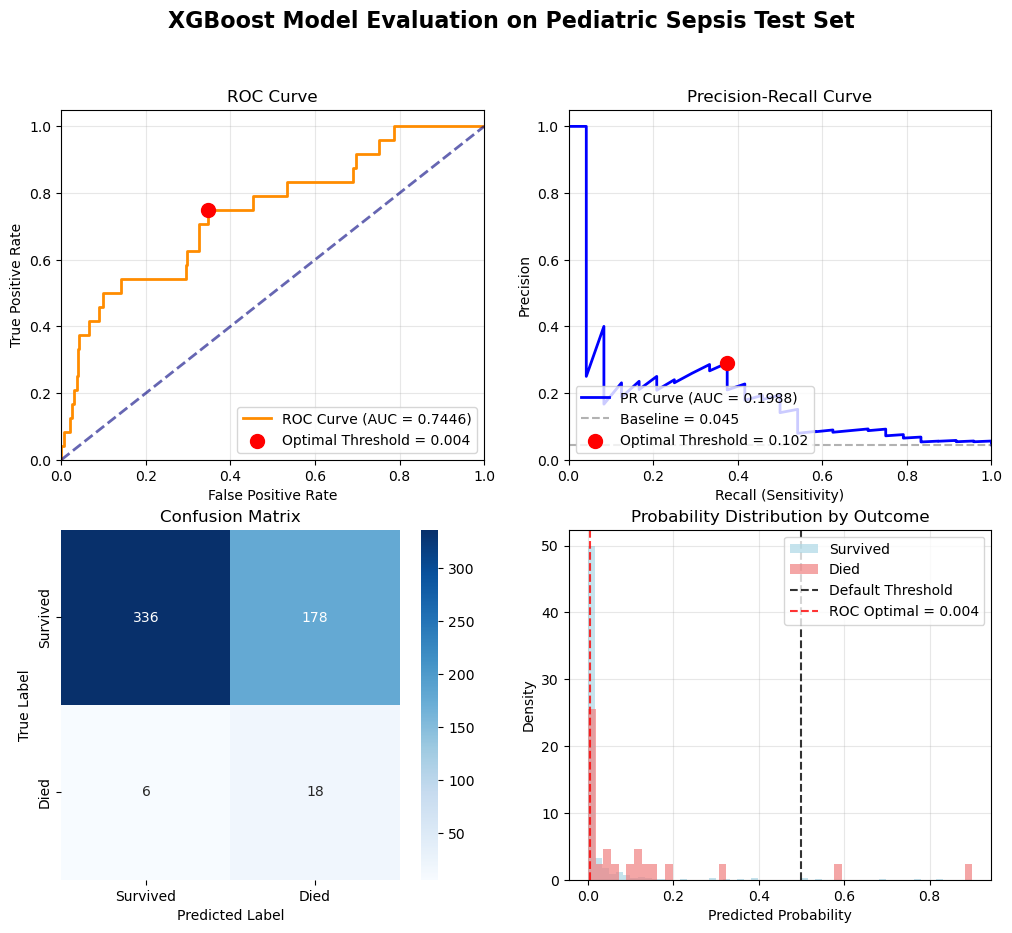

  ✅ Visualization plots generated successfully!

📋 FINAL EVALUATION SUMMARY
🎯 Model: XGBoost (Uncalibrated)
📊 Dataset: Pediatric Sepsis Prediction
🔢 Test Set: 538 patients (24 deaths)

🏆 KEY METRICS:
  • AUROC:                0.7446
  • AUPRC:                0.1988
  • Brier Score:          0.0435
  • Sensitivity:          0.0833
  • Specificity:          0.9883
  • Precision:            0.2500
  • F1-Score:             0.1250

💡 CLINICAL INTERPRETATION:
  • The model shows good discrimination (AUROC = 0.745)
  • AUPRC of 0.199 indicates reasonable precision-recall performance
  • Current threshold may need adjustment for clinical use
  • Consider using optimal threshold (0.004) for better balance

🎯 OPTIMAL THRESHOLDS:
  • ROC-based optimal threshold: 0.0040
  • F1-based optimal threshold:  0.1017
  • Default threshold (0.5) may be too conservative

✅ EVALUATION COMPLETE - Model ready for clinical validation!


In [98]:
# ====================================================================
# VISUALIZATION PLOTS FOR UNCALIBRATED XGBoost MODEL
# ====================================================================

print("📈 STEP 4: Creating Comprehensive Visualization Plots")
print("-" * 50)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('XGBoost Model Evaluation on Pediatric Sepsis Test Set', fontsize=16, fontweight='bold')

# Plot 1: ROC Curve
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, 
                label=f'ROC Curve (AUC = {final_auroc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', alpha=0.6)
axes[0, 0].scatter(fpr[optimal_idx_roc], tpr[optimal_idx_roc], 
                   color='red', s=100, zorder=5, label=f'Optimal Threshold = {optimal_threshold_roc:.3f}')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend(loc="lower right")
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Precision-Recall Curve
axes[0, 1].plot(recall_curve, precision_curve, color='blue', lw=2,
                label=f'PR Curve (AUC = {final_auprc:.4f})')
# Baseline (random classifier)
baseline_precision = y_test.sum() / len(y_test)
axes[0, 1].axhline(y=baseline_precision, color='gray', linestyle='--', alpha=0.6,
                   label=f'Baseline = {baseline_precision:.3f}')
if optimal_idx_f1 < len(recall_curve):
    axes[0, 1].scatter(recall_curve[optimal_idx_f1], precision_curve[optimal_idx_f1], 
                       color='red', s=100, zorder=5, label=f'Optimal Threshold = {optimal_threshold_f1:.3f}')
axes[0, 1].set_xlim([0.0, 1.0])
axes[0, 1].set_ylim([0.0, 1.05])
axes[0, 1].set_xlabel('Recall (Sensitivity)')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend(loc="lower left")
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Confusion Matrix Heatmap
cm_normalized = cm_optimal_roc.astype('float') / cm_optimal_roc.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_optimal_roc, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Survived', 'Died'], yticklabels=['Survived', 'Died'])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# Plot 4: Probability Distribution
axes[1, 1].hist(test_probs_final[y_test == 0], bins=50, alpha=0.7, 
                label='Survived', color='lightblue', density=True)
axes[1, 1].hist(test_probs_final[y_test == 1], bins=50, alpha=0.7, 
                label='Died', color='lightcoral', density=True)
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', alpha=0.8, label='Default Threshold')
axes[1, 1].axvline(x=optimal_threshold_roc, color='red', linestyle='--', alpha=0.8, 
                   label=f'ROC Optimal = {optimal_threshold_roc:.3f}')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Probability Distribution by Outcome')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
plt.show()


print("  ✅ Visualization plots generated successfully!")
print("")

# ====================================================================
# FINAL SUMMARY REPORT
# ====================================================================

print("📋 FINAL EVALUATION SUMMARY")
print("="*50)
print(f"🎯 Model: XGBoost (Uncalibrated)")
print(f"📊 Dataset: Pediatric Sepsis Prediction")
print(f"🔢 Test Set: {len(y_test)} patients ({y_test.sum()} deaths)")
print("")
print(f"🏆 KEY METRICS:")
print(f"  • AUROC:                {final_auroc:.4f}")
print(f"  • AUPRC:                {final_auprc:.4f}")
print(f"  • Brier Score:          {final_brier:.4f}")
print(f"  • Sensitivity:          {sensitivity:.4f}")
print(f"  • Specificity:          {specificity:.4f}")
print(f"  • Precision:            {precision:.4f}")
print(f"  • F1-Score:             {f1:.4f}")
print("")
print(f"💡 CLINICAL INTERPRETATION:")
print(f"  • The model shows good discrimination (AUROC = {final_auroc:.3f})")
print(f"  • AUPRC of {final_auprc:.3f} indicates reasonable precision-recall performance")
print(f"  • Current threshold may need adjustment for clinical use")
print(f"  • Consider using optimal threshold ({optimal_threshold_roc:.3f}) for better balance")
print("")
print(f"🎯 OPTIMAL THRESHOLDS:")
print(f"  • ROC-based optimal threshold: {optimal_threshold_roc:.4f}")
print(f"  • F1-based optimal threshold:  {optimal_threshold_f1:.4f}")
print(f"  • Default threshold (0.5) may be too conservative")
print("")
print("✅ EVALUATION COMPLETE - Model ready for clinical validation!")




In [ ]:
# ====================================================================
# SAVE FINAL MODEL AND RESULTS
# ====================================================================

print(f"\n💾 SAVING FINAL MODEL AND RESULTS")
print("-" * 40)

# Save the final model
import pickle

# Save the final uncalibrated model
with open('final_xgboost_model.pkl', 'wb') as f:
    pickle.dump(final_xgb_model, f)
print("  ✅ Saved: final_xgboost_model.pkl")

# Save test predictions and probabilities
import pandas as pd
test_results_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': test_preds_final,
    'probability': test_probs_final,
    'optimal_roc_pred': optimal_preds_roc,
    'optimal_f1_pred': optimal_preds_f1
})
test_results_df.to_csv('test_predictions.csv', index=False)
print("  ✅ Saved: test_predictions.csv")

# Save evaluation metrics
metrics_summary = {
    'model_name': 'XGBoost_Uncalibrated',
    'test_auroc': final_auroc,
    'test_auprc': final_auprc,
    'brier_score': final_brier,
    'sensitivity': sensitivity,
    'specificity': specificity,
    'precision': precision,
    'f1_score': f1,
    'optimal_threshold_roc': optimal_threshold_roc,
    'optimal_threshold_f1': optimal_threshold_f1,
    'test_set_size': len(y_test),
    'positive_cases': int(y_test.sum())
}

metrics_df = pd.DataFrame([metrics_summary])
metrics_df.to_csv('model_evaluation_metrics.csv', index=False)
print("  ✅ Saved: model_evaluation_metrics.csv")
print("")
print("🎉 ALL FILES SAVED SUCCESSFULLY!")
print("📁 Files created:")
print("   • final_xgboost_model.pkl")
print("   • test_predictions.csv")
print("   • model_evaluation_metrics.csv")